<h1 align="center">
Topic modeling on Medium articles
</h1>

In [1]:
## All minimum setup and libraries required

import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## TENSORFLOW        
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer   ## Generate dictionary of word encodings
from tensorflow.keras.preprocessing.sequence import pad_sequences

## GENSIM and NLTK
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')

# SKLEARN
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

print("Tensorflow\t-\t",tf.__version__)
print("NLTK\t\t-\t",nltk.__version__)
print("Gensim\t\t-\t",nltk.__version__)

/kaggle/input/medium-articles-with-content/Medium_AggregatedData.csv
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
Tensorflow	-	 2.3.0
NLTK		-	 3.2.4
Gensim		-	 3.2.4


In [3]:
path = "../input/medium-articles-with-content/Medium_AggregatedData.csv"
dataframe_full = pd.read_csv(path)
dataframe_imp = pd.read_csv(path)
print("Dataset has been read")

Dataset has been read


In [4]:
dataframe_full.head()

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,...,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
3,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,...,technology,Technology,166125.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104
4,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,...,robotics,Robotics,9103.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104


In [5]:
x = dataframe_full['name'][10]
y = dataframe_full['publicationdescription'][15]
print(x)
print(y)
print(dataframe_full.shape)
print(dataframe_full['name'][10])
print(dataframe_full['name'][11])
print(dataframe_full['name'][12])
print(dataframe_full['title'][10])

Big Data Training Mumbai
Non-obvious meditation advice from people on the battlefront of daily creation
(279577, 50)
Big Data Training Mumbai
Robotics
Meditation
Ascent of data Science, SAS and Big data Analyst Trainings Programs


# Step_1: Preprocessing and cleaning

**There are ~300000 entries**

In [6]:
print(dataframe_full.columns)

Index(['audioVersionDurationSec', 'codeBlock', 'codeBlockCount',
       'collectionId', 'createdDate', 'createdDatetime', 'firstPublishedDate',
       'firstPublishedDatetime', 'imageCount', 'isSubscriptionLocked',
       'language', 'latestPublishedDate', 'latestPublishedDatetime',
       'linksCount', 'postId', 'readingTime', 'recommends',
       'responsesCreatedCount', 'socialRecommendsCount', 'subTitle',
       'tagsCount', 'text', 'title', 'totalClapCount', 'uniqueSlug',
       'updatedDate', 'updatedDatetime', 'url', 'vote', 'wordCount',
       'publicationdescription', 'publicationdomain',
       'publicationfacebookPageName', 'publicationfollowerCount',
       'publicationname', 'publicationpublicEmail', 'publicationslug',
       'publicationtags', 'publicationtwitterUsername', 'tag_name', 'slug',
       'name', 'postCount', 'author', 'bio', 'userId', 'userName',
       'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'],
      dtype='object')


The required columns are:
* language
* subTitle
* tagsCount
* text
* title
* url
* wordCount
* publicationdescription
* tag_name
* name

but the most important columns are primarily:
* subTitle
* text
* title

In [7]:
required_col = ['language','subTitle','tagsCount','text','title','url','wordCount','publicationdescription'
               ,'tag_name','name']
most_imp_col = ['subTitle','text','title']

In [8]:
# article_titles = dataframe_full['title']
# art_grp_1 = article_titles[16:25]
# print(art_grp_1)
print(dataframe_full.language.unique())

['en' 'th' 'ja' 'zh' 'ru' 'pt' 'es' 'zh-Hant' 'id' 'my' 'de' 'tr' 'fr'
 'ko' 'it' 'lo' 'un' 'vi' 'cs' 'sk' 'is' 'sv' 'bn' 'mn' 'da' 'no' 'bg'
 'ar' 'pl' 'nl' 'ro' 'ca' 'hu' 'hi' 'ka' 'el' 'ms' 'uk' 'si' 'sr' 'lt'
 'la' 'fa' 'ml' 'sl' 'mr' 'az' 'lv' 'te' 'mk' 'nn' 'fi']


In [9]:
## Number of rows english rows

english_titles = dataframe_full[dataframe_full['language'] == 'en']
# english_titles.head()
print(english_titles.shape)

(257655, 50)


In [10]:
## Number of rows dropped after removing null value rows

print(dataframe_imp.shape)
dataframe_imp.dropna(how = 'all')
print(dataframe_imp.shape)

(279577, 50)
(279577, 50)


So nothing is missing in any rows

In [11]:
## After dropping non-english and columns that are not required really

dataframe_imp.drop(dataframe_imp[dataframe_imp['language'] != 'en'].index, inplace = True)

dataframe_imp = dataframe_imp.drop(['audioVersionDurationSec', 'codeBlock', 'codeBlockCount',
       'collectionId', 'createdDate', 'createdDatetime', 'firstPublishedDate',
       'firstPublishedDatetime', 'imageCount', 'isSubscriptionLocked',
       'language', 'latestPublishedDate', 'latestPublishedDatetime',
       'linksCount', 'postId', 'readingTime', 'recommends',
       'responsesCreatedCount', 'socialRecommendsCount','tagsCount','totalClapCount', 'uniqueSlug',
       'updatedDate', 'updatedDatetime', 'url', 'vote', 'wordCount',
       'publicationdescription', 'publicationdomain',
       'publicationfacebookPageName', 'publicationfollowerCount',
       'publicationname', 'publicationpublicEmail', 'publicationslug',
       'publicationtags', 'publicationtwitterUsername', 'tag_name', 'slug',
       'name', 'postCount', 'author', 'bio', 'userId', 'userName',
       'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'], axis=1)

dataframe_imp['index'] = dataframe_imp.index

dataframe_imp.shape

(257655, 4)

### Reduced dataset with 3col and ~20000 rows for reff.
Run these cells only to produce the reduced and compact dataset

In [12]:
## Run these cell to export the new trimmed down dataset

# dataframe_imp.to_csv("medium_dataset.csv",sep=",")
# new_ds_size = os.stat("medium_dataset.csv").st_size
# new_ds_size = new_ds_size / 1000000
# print("New dataset size in MB = ",new_ds_size)

***Choose one among the two in the cell below***

In [13]:
## Keeping 170000 rows greatly reduces the dataset size to around 100MB

very_reduced_dataset = dataframe_imp[:17000]
# very_reduced_dataset.to_csv("very_reduced_dataset.csv",sep=",")
# print("New dataset size in MB = ",os.stat("very_reduced_dataset.csv").st_size / 1000000)

# from IPython.display import FileLink
# FileLink(r'very_reduced_dataset.csv')

In [14]:
dataframe_imp.head()

,subTitle,text,title,index
0,A major private IT company implements blockcha...,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",0
1,A major private IT company implements blockcha...,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",1
2,A major private IT company implements blockcha...,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",2
3,Introduction,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),3
4,Introduction,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),4


In [15]:
print(dataframe_imp.title[15])
print(dataframe_imp.subTitle[15])
# print(dataframe_imp.text[15])      ## Text is too huge to be displayed
print(dataframe_imp.index[15])

Can a robot love us better than another human can?
I discussed this with Michelle Tsng on my Podcast “Crazy Wisdom”.
15


**after dropping all the non english rows and after dropping all non essential columns `dataframe_imp` is the required dataframe****

### Perform lemmatization and stem preprocessing steps on the data set

In [16]:
## Stemmer initialization for english
stemmer = SnowballStemmer("english")

In [17]:
## Functions for lemmatization, removal of Stopwords

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))  #does lemitazation and then stemming

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):   #converts doc into tokens
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:    #if the token is not stopword + len>3
            result.append(lemmatize_stemming(token))   # then lemitize and add stem
    return result

In [18]:
### Code to check the function

## Run this for faster execution time wiht less acuracy
doc_sample = very_reduced_dataset[very_reduced_dataset['index'] == 1000].values[0][2]

## Run this for slower execution but better accuracy
# doc_sample = dataframe_imp[dataframe_imp['index'] == 1000].values[0][2]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
    
print(dataframe_imp[dataframe_imp['index'] == 1000].values[0][2])
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
Machine Learning Made Easy: What it is and How it Works
['Machine', 'Learning', 'Made', 'Easy:', 'What', 'it', 'is', 'and', 'How', 'it', 'Works']


 tokenized and lemmatized document: 
['machin', 'learn', 'easi', 'work']


### Processed titles

In [19]:
## Use this to reduce the training time at the cost of loss of rows and some accuracy.
title_list = very_reduced_dataset['title'].astype(str)

## Use this for higher model accuracy but very slow operating time. 
# title_list = dataframe_imp['title'].astype(str)   ## using astype(str) eliminates the floting type error
title_list.describe()

count                           17000
unique                           4436
top       10 new things to read in AI
freq                               24
Name: title, dtype: object

In [20]:
## The titles are preprocessed and saved into processd_titles
## The map function applies the preprocess method on each of the list entries

processed_titles = title_list.map(preprocess)
processed_titles[30:40]

34    [meta, model, meta, meta, model, deep, learn]
35    [meta, model, meta, meta, model, deep, learn]
36               [tip, data, scienc, team, succeed]
37               [tip, data, scienc, team, succeed]
38               [tip, data, scienc, team, succeed]
39                                   [trust, trust]
40                                   [trust, trust]
41                                   [trust, trust]
42                                   [trust, trust]
43                                   [trust, trust]
Name: title, dtype: object

# Step_2: Creation of the Bag of words
Bag of words is a frequency count of the words occuring in the `preprocessed_docs`

In [21]:
## bow --> Bag of Words

bow = gensim.corpora.Dictionary(processed_titles)

## Finding out words with a min_occurance = 10

min_occurance = 10
count = 0
for k, v in bow.iteritems():
    print(k, v)
    count += 1
    if count > min_occurance:    # We can limit the selection based on the frequency
        break

0 blockchain
1 busi
2 govern
3 privat
4 draft
5 word
6 analyst
7 ascent
8 data
9 program
10 scienc


### Filtering tokens based on
* less than 15 occurances in titles
* more than 0.5 of total titles
* after the above two steps, keep only the first 100000 most frequent tokens.


In [22]:
bow.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print(bow)

Dictionary(932 unique tokens: ['blockchain', 'busi', 'govern', 'privat', 'draft']...)


### Generating the doc2bow dictionary

For each title we create a dictionary reporting how many words and how many times those words appear. This is saved to the `bow_corpus`.

##### **NOTE:** This step gives a simmillar result for a very small corpus such as title of the articles, but it is important while working on the actual body of the articles.

In [23]:
bow_corpus = [bow.doc2bow(doc) for doc in processed_titles]
bow_corpus[:10]

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1)],
 [(4, 1), (5, 1)],
 [(4, 1), (5, 1)],
 [(4, 1), (5, 1)],
 [(6, 1), (7, 2), (8, 1), (9, 1), (10, 1)],
 [(6, 1), (7, 2), (8, 1), (9, 1), (10, 1)],
 [(6, 1), (7, 2), (8, 1), (9, 1), (10, 1)]]

### Preview of the BOW for the preprocessed titles

In [24]:
## A example of the BOW for the 1000th title

bow_example = bow_corpus[1000]
for i in range(len(bow_example)):
    print("Word {} (\"{}\") appears {} time.".format(bow_example[i][0], 
           bow[bow_example[i][0]], 
           bow_example[i][1]))

Word 101 ("fake") appears 1 time.
Word 228 ("photo") appears 1 time.
Word 419 ("believ") appears 1 time.
Word 420 ("game") appears 1 time.
Word 421 ("generat") appears 1 time.


# Step_3: TF-IDF 
TF-IDF stands for ***term frequency–inverse document frequency***. The higher the TF-IDF score the rarer a word is in a given corpus and vice-versa. We will be using the TF-IDF model for the gensim models library.

In [25]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# from pprint import pprint

for i in corpus_tfidf:
    print(i)
    break

[(0, 0.37967924604419184), (1, 0.38510895463809597), (2, 0.5734341889792183), (3, 0.6153925528397408)]


# Step_4: Running LDA algo on the bag of words
Testing LDA(Latent Dirichlet allocation) on the BOW. We will be training our LDA model using `gensim.models.LdaMulticore` and save it to `lda_model`

### Creating the base model

In [26]:
## LDA when the num_topics = 10

# lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=bow, passes=5, workers=3)
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=bow,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
print(lda_model)
# For optimal performance time set the workers as no of CPU cores-1

LdaModel(num_terms=932, num_topics=10, decay=0.5, chunksize=100)


**For each topic, we will explore the words occuring in that topic and its relative weight.**

### Topic distribution generated by the model

In [27]:
for idx, topic in lda_model.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))
doc_lda = lda_model[bow_corpus]


Topic: 0 
Words: 0.045*"classif" + 0.044*"time" + 0.041*"manag" + 0.038*"scientist" + 0.036*"digit" + 0.035*"know" + 0.035*"engin" + 0.035*"think" + 0.034*"transform" + 0.028*"real"

Topic: 1 
Words: 0.056*"autom" + 0.053*"work" + 0.050*"python" + 0.042*"experi" + 0.038*"custom" + 0.033*"improv" + 0.029*"better" + 0.029*"meet" + 0.028*"team" + 0.025*"talk"

Topic: 2 
Words: 0.072*"network" + 0.052*"neural" + 0.046*"market" + 0.042*"build" + 0.039*"chang" + 0.039*"news" + 0.036*"realiti" + 0.031*"tech" + 0.027*"algorithm" + 0.025*"facebook"

Topic: 3 
Words: 0.187*"intellig" + 0.168*"artifici" + 0.028*"understand" + 0.026*"chatbot" + 0.025*"research" + 0.020*"tool" + 0.020*"generat" + 0.019*"educ" + 0.017*"problem" + 0.015*"startup"

Topic: 4 
Words: 0.094*"human" + 0.064*"robot" + 0.049*"week" + 0.047*"imag" + 0.039*"read" + 0.034*"product" + 0.030*"languag" + 0.025*"natur" + 0.024*"kera" + 0.023*"process"

Topic: 5 
Words: 0.050*"busi" + 0.049*"power" + 0.045*"thing" + 0.037*"industr

In [28]:
topics = lda_model.show_topics(formatted=False)
topic_words = dict(topics[1][1])
print("For topic 1, the words are: ",topic_words)

For topic 1, the words are:  {'autom': 0.05565078, 'work': 0.052944787, 'python': 0.050341874, 'experi': 0.04165743, 'custom': 0.03782384, 'improv': 0.032869827, 'better': 0.028755257, 'meet': 0.028711578, 'team': 0.027950928, 'talk': 0.024631334}


<h3 style="color:blue;">Here each topic can be visualized as recipie of the probability of the words that can appear in it.</h3>In geometry, a simplex is a generalization of the notion of a triangle or tetrahedron to arbitrary dimensions [source] (https://en.wikipedia.org/wiki/Simplex). LDA space is a simplex since we are dealing wiht probability distributions here. Dimensionality of the space depends on the number of topics we ask the model to make.

# Step_5: Visualization 
1. Topic modeling with LDA
2. Visualizing topic models with pyLDAvis
3. Visualizing LDA results with t-SNE and bokeh

In [29]:
%pylab inline

import pandas as pd
import pickle as pk
from scipy import sparse as sp

Populating the interactive namespace from numpy and matplotlib


In [ ]:
Each word in the document is representative of one of the topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document

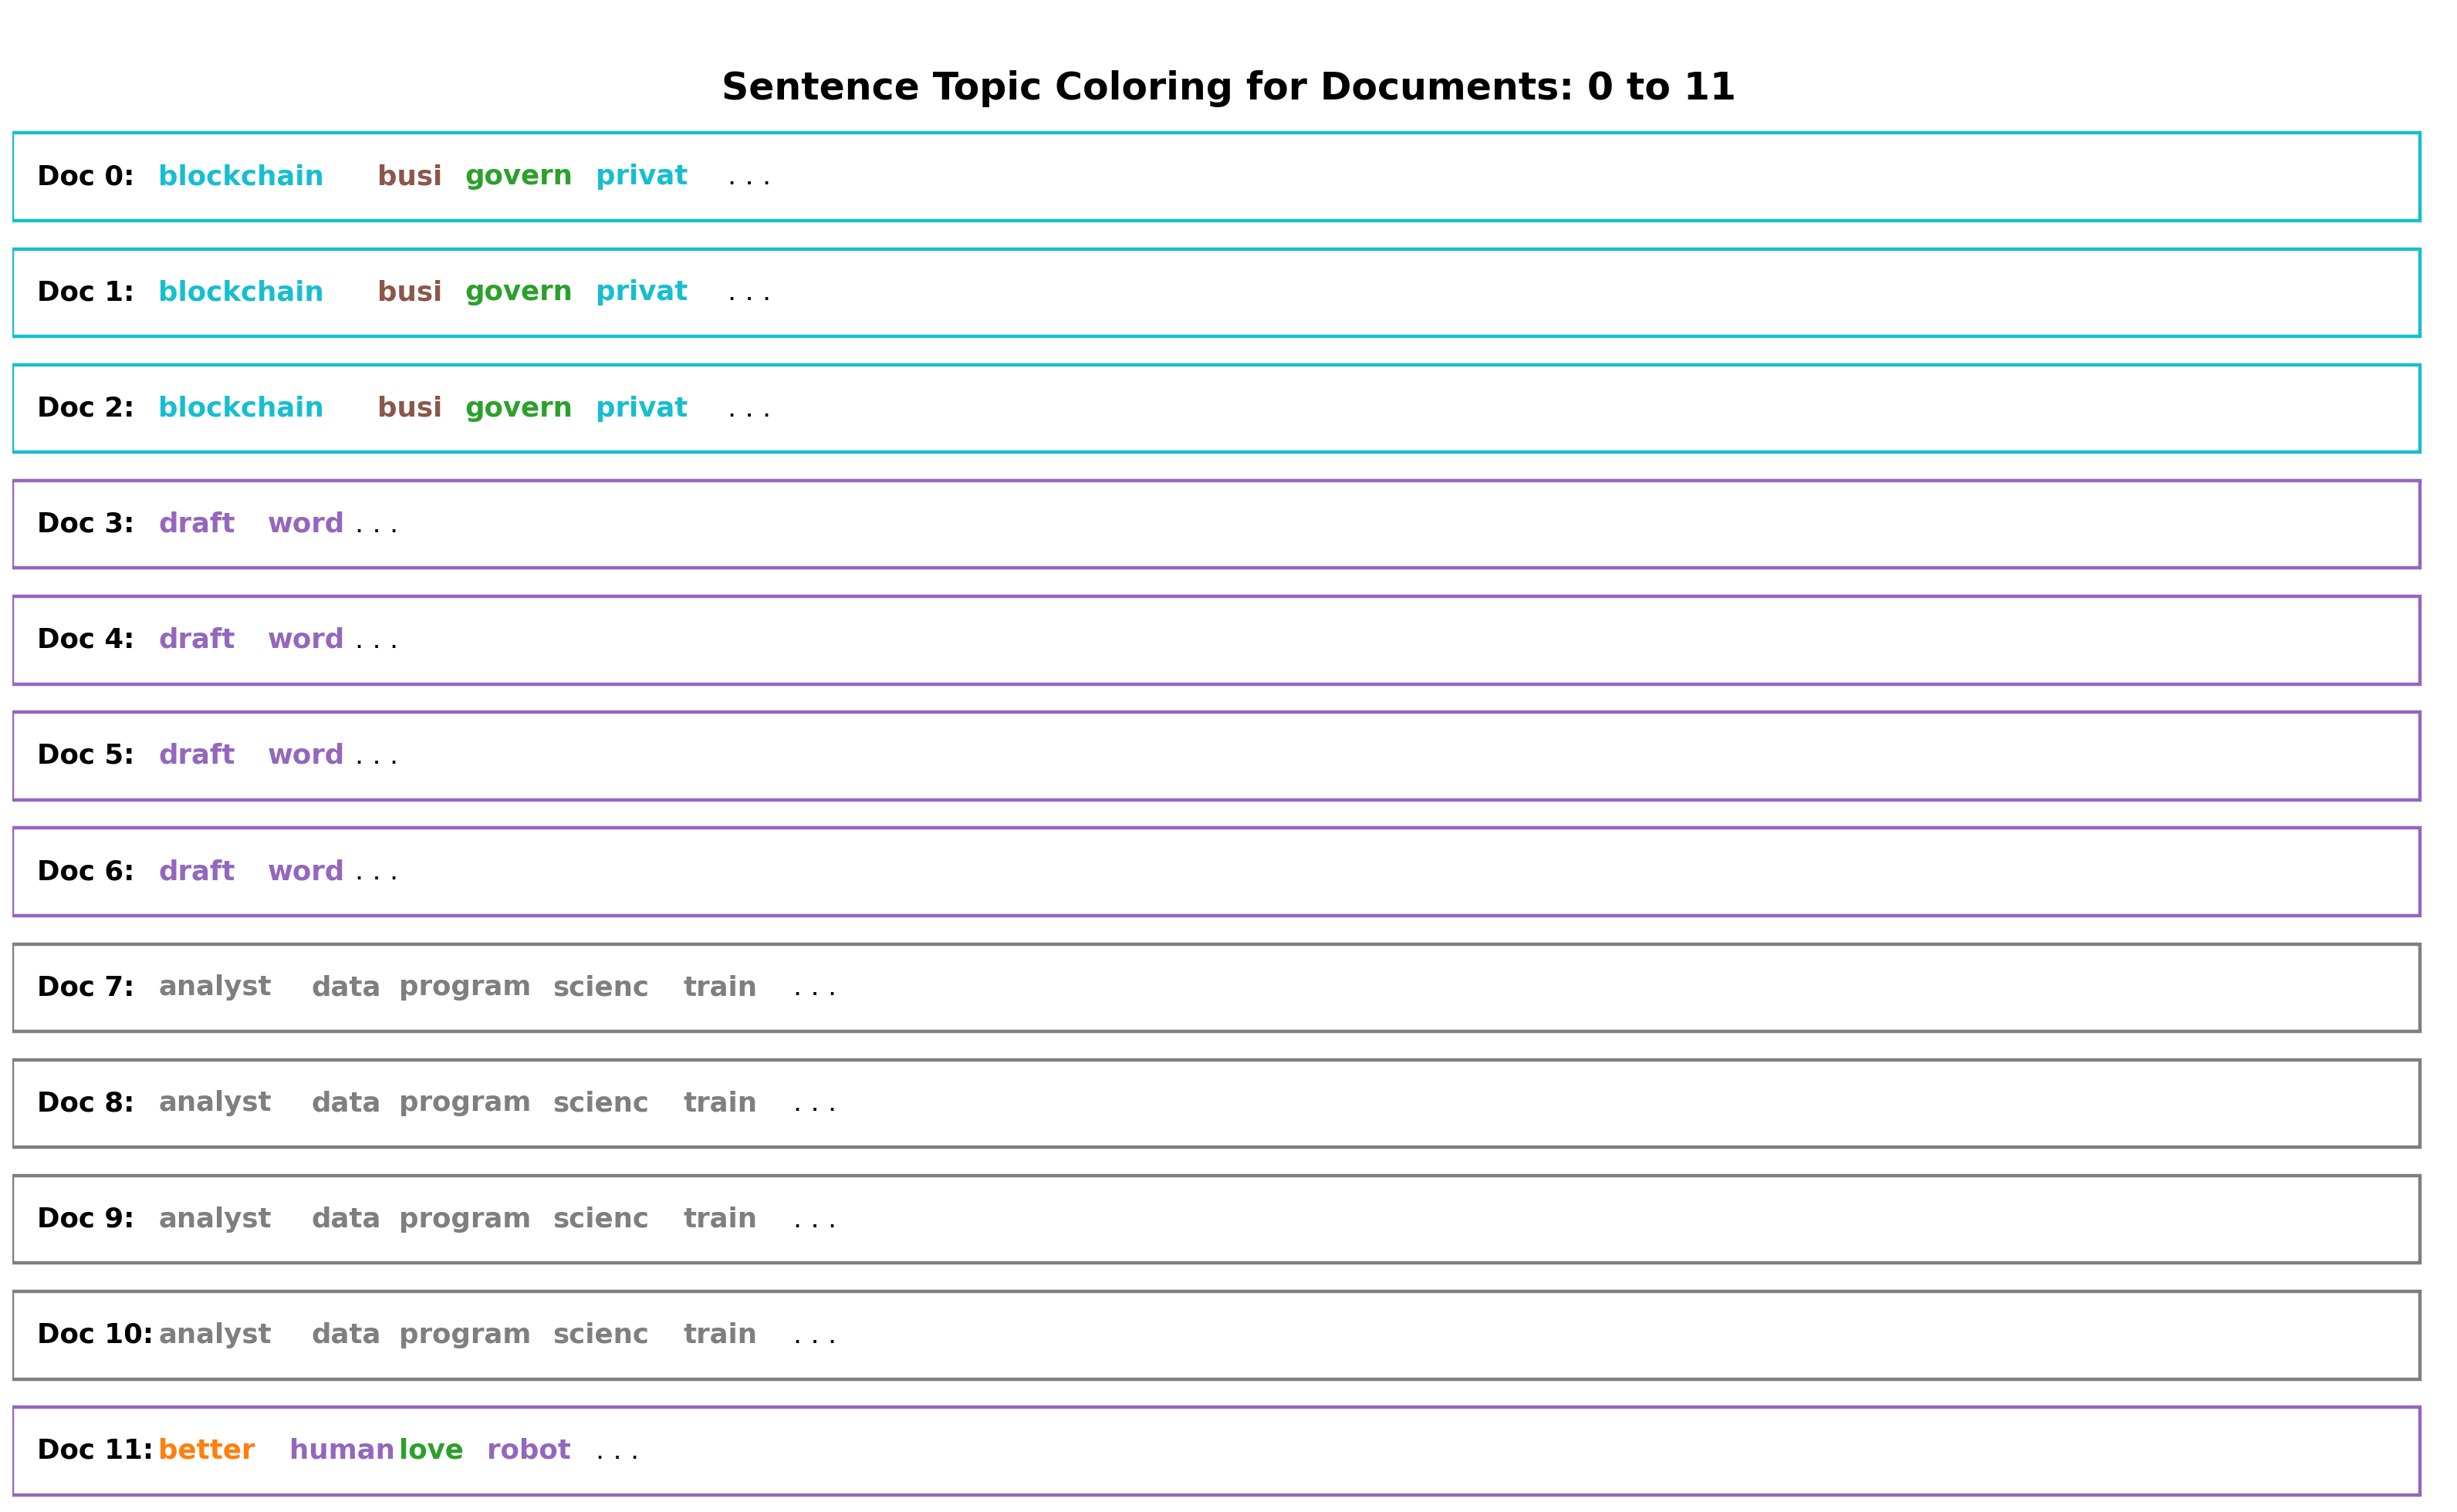

In [30]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
#cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

def sentences_chart(lda_model=lda_model, corpus=bow_corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

## Wordcloud of Top N words in each topic

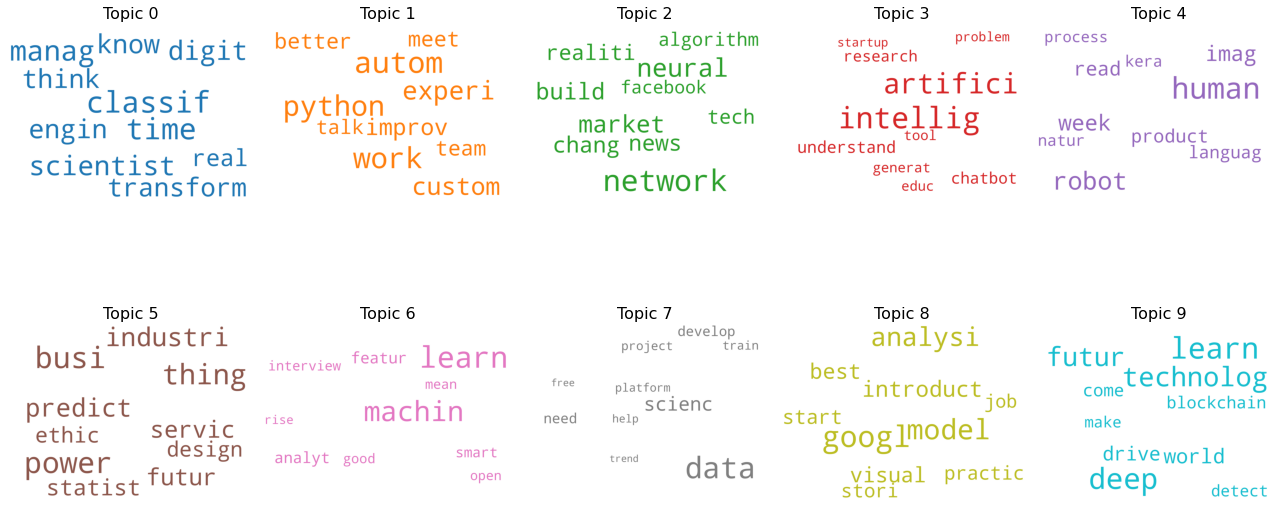

In [31]:
## Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(18,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word count vs Weights of topics

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in dataframe_imp for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 5, figsize=(18,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.08); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()